# Tutorial Dynamic Inflow

#### Created in May 2020 by:   
Prof. Carlos Ferreira  
Chair Wind Energy Science  
TUDelft, Faculty of Aerospace Engineering  

#### Learning objectives:
The student will:

- Learn an approach for the implementation of three enginnering models for the simulation of dynamic inflow: Pitt-Peters, &Oslash;ye and Larsen-Madsen

- Compare how the three models result in different predictions of the dynamic induction


#### References for additional study of dynamic inflow

- W. Yu. The wake of an unsteady actuator disc. PhD thesis, Delft University
of Technology, 2018. URL http://resolver.tudelft.nl/uuid:0e3a2402-585c-41b1-81cf-a35753076dfc
- Wessel van der Deijl. Dynamic wind speed in dynamic inflow models. Master’s
thesis, Delft University of Technology, July 2018. URL http://resolver.tudelft.nl/uuid:da585fef-bd98-4519-962b-e1ccc62c906a
- Delphine De Tavernier and Carlos S. Ferreira. A new dynamic inflow model for
vertical-axis wind turbines. Wind Energy, 23(5):1196–1209, 2020. doi: 10.1002/we.2480. URL https://onlinelibrary.wiley.com/doi/abs/10.1002/we.2480
- David A. Peters. How dynamic inflow survives in the competitive world of rotorcraft
aerodynamics. Journal of the American Helicopter Society, 54(1), 2009.
ISSN 2161-6027. doi: doi:10.4050/JAHS.54.011001. URL https://www.ingentaconnect.com/content/ahs/jahs/2009/00000054/00000001/art00003


In [1]:
# Here we import import the python libraries we will use
import matplotlib.pyplot as plt # import pyplot library
import matplotlib.colors as colors # import colors library
import numpy as np # import numpy
# import matplotlib

The equations below express the induction factor $a$ as a function of thrust coefficient $C_T$, and $C_T$ as a function of $a$.

Our original assumption of the relation between loading on the actuator and induction is given by the equations below.
</p>
<p>$C_T=4 a \left( 1 -a  \right)$</p>
<p>and</p>
<p>$a = \frac{1}{2}\left( 1 - \sqrt{1-C_T} \right)$</p>
<p>
Above a certain loading on the streamtube, the wake will enter "turbulent wake state" or even "vortex ring state".
The relations above are no longer valid, and should be corrected.

### Glauert's correction for heavily loaded rotors 
<p>
  One proposed correction was defined by Glauert, and it is given by the equations below.
</p>

$C_T= \left\{ {\begin{array}{{c}}
  {4 a \left( 1 -a  \right) \text{, for } a< 1- \frac{\sqrt{C_{T_1}}}{2} }\\
  {C_{T_1}-4 \left(\sqrt{C_{T_1}} -1  \right) \left( 1 -a  \right)  \text{, for } a \ge 1- \frac{\sqrt{C_{T_1}}}{2}  }
\end{array}} \right.
$

$ a = \left\{ {\begin{array}{{c}} 
{ \frac{1}{2} - \frac{\sqrt{1-C_{T}}}{2} \rm{,~for~} C_T < C_{T_2} }\\
  {1+\frac{C_T-C_{T_1} }{4\sqrt{C_{T_1}} - 4}  \rm{,~for~} C_T \ge C_{T_2}  }
  \end{array}} \right. $
<p>and</p>
<p>$C_{T_1}=1.816$ and $C_{T_2}= 2\sqrt{C_{T_1}} - C_{T_1}$</p>


In [2]:
# induction as a function of thrust coefficient 

def ainduction(CT,glauert=False):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction. Notice that here we are using the wind turbine notation of 'a' 
    """    
    if glauert:
        CT1=1.816;
        CT2=2*np.sqrt(CT1)-CT1
    else:
        CT1=0
        CT2=100
    
    a=np.zeros(np.shape(CT))
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a


def CTfunction(a, glauert = False):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT


The Pitt-Peters dynamic inflow model
------------------------------------

The linear Pitt-Peters dynamic-inflow model is shown in the equation
below for the case of axial flow in $x$-direction

-   for an annulus at radius $r_j$ with area $A_j$

-   for a loading on the annulus $T$

-   where $v_x$ is the perturbation velocity at the rotor (induced
    velocity)

$$\label{eq:pittpeters_dynamic_inflow_model}
\left[\frac{8}{3 \pi }r_j \rho A_j \frac{\rm{d} v_x}{\rm{d} t} + 2 \rho A_j v_x \left(U_infty +v_x \right)\right] = T$$


### The Pitt-Peters dynamic inflow model: application to heavy loaded cases

The equation for the Pitt-Peters dynamic-inflow model can be rewritten
as

$$\label{eq:pittpeters_dynamic_inflow_model_CT_based}
\frac{\rm{d} v_x}{\rm{d} t}  = \frac{3\pi U_\infty}{16 r_j}\left[\frac{T}{1/2 \rho A_j U_\infty^2} - 4 \frac{v_x \left(U_infty +v_x \right)}{U_\infty^2}\right]$$

and further as

$$\label{eq:pittpeters_dynamic_inflow_model_CT_based_glauert}
\frac{\rm{d} v_x}{\rm{d} t}  = \frac{3\pi U_\infty}{16 r_j}\left[C_{T_{load}}- C_{T_{\left( v_x/U_\infty \right)}}\right]$$

where $C_{T_{load}}$ in the non-dimensional thrust applied to the
annulus and $C_{T_{\left( v_x/U_\infty \right)}}$ is the expression for
actuator disk momentum theory.


In [3]:
# The Pitt-Peters dynamic inflow model

def pitt_peters(Ct,vind,Uinf,R,dt,glauert=False ):
    # this function determines the time derivative of the induction at the annulli 
    # Ct is the thrust coefficient on the actuator, vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow, nd dt is the time step
    # it returns the new value of induction vindnew and the time derivative dvind_dt
    # glauert defines if glauert's high load correction is applied
    
    a=-vind/Uinf # determine the induction coefficient for the time step {i-1}
    Ctn= -CTfunction(a, glauert) # calculate the thrust coefficient from the induction for the time step {i-1}

    dvind_dt =  (Ct-Ctn)/(16/(3*np.pi))*(Uinf**2/R) # calculate the time derivative of the induction velocity
    vindnew = vind + dvind_dt*dt # calculate the induction at time {i} by time integration
    return vindnew, dvind_dt
    

In [38]:
# we will now calculate and plot the solution of a step change in thrust coefficient

# we define the value of U_infinity and the radius of the actuator
Uinf=1 # U_infinity
R=1 # radius of the actuator

# define time array
dt=0.005 # we define the time step
time=np.arange(0, 20, dt) # we create the array "time"


# define Ct and induction at  t0
Ct0=np.array([-.5])  # this it the value of thrust coefficient at time t0, the start of the time array
vind0=-ainduction(-Ct0)*Uinf # this is the quasi-steady value of induction at time t0, calculated from Ct0

# define quasi-steady solution of Ct and induction at  t>=t1
Ct1=np.array([-0.85]) # this it the value of thrust coefficient at time t1
vind1=-ainduction(-Ct1)*Uinf # this is the quasi-steady value of induction at time t1, calculated from Ct1

# define Ct as a function of time
Ct = np.zeros(np.shape(time))+Ct0 # we initialize the array of thrust coefficient, setting all initial values at Ct0

# change Ct for time above t1
t1=5 # we define t1, when Ct experiences a step change
Ct[time>=t1] = Ct1 # we correct the values of Ct for the instants that time is after t1, to a value of Ct1. We therefore 
                    # define the step change from Ct0 to Ct1
    
#set arrays for induction
vind = np.zeros(np.shape(time)) # we create the array of induction velocity
vind[0]=vind0 # we initialize the first value to the induction velocity at t0, calculated from Ct0


# solve the equation in time of the value of induction by using the Pitt-Peters model 
for i,val in enumerate(time[:-1]):
    vind[i+1]=pitt_peters(Ct[i+1],vind[i],Uinf,R,dt )[0]
    

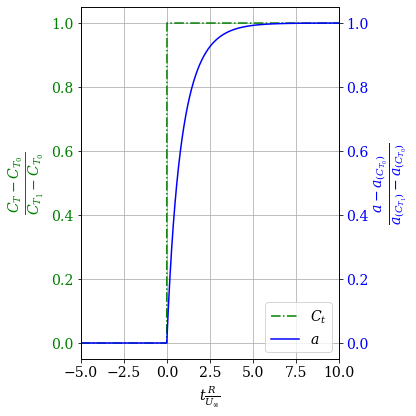

In [40]:
# plot figure the change in induction factor $a$  calculated by the Pitt-peters model for a step change in thrust coefficient 
# from $C_{t_0}=0.5$ to $C_{t_0}=0.85$. The values are made non-dimensioned by the steady-solution values of $a$ 
# for the two values of $C_t$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
# the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')  # define a colormap for the figure
fig,ax1 = plt.subplots(figsize=[6,6]) # create figure, axis and define the size of the figure
ax2=ax1.twinx() # we twin the axis to create a seondary y-axis. therefore, we twin the x-axis
# we now plot the evolution of Ct over time
lns1=ax1.plot((time-t1)*R/Uinf, (Ct-Ct0)/(Ct1-Ct0), color='green',linestyle='dashdot', label=r'$C_t$') # notice the negative 
                                                              # value as we wil be using the notation for wind tuubines
# we now plot the evolution of induction velocity over time in the secondary axis
lns2=ax2.plot((time-t1)*R/Uinf, (vind-vind0)/(vind1-vind0), color='blue',linestyle='-', label= r'$a$') # notice the negative 

# define properties of the primary y-axis
# ax1.set_aspect(aspect=20.0) # set aspect ratio of the figure
ax1.set_xlabel(r'$t \frac{R}{U_\infty}$') # label of x-axis
ax1.set_ylabel(r'$\frac{C_T-C_{T_0}}{C_{T_1}-C_{T_0}}$', 
               color='green', fontsize=20) # label of y-axis
ax1.set_xlim(-t1,10) # set limits of x-axis   
ax1.set_ylim(-0.05,1.05) # set limits of x-axis   
ax1.tick_params(axis='y', labelcolor='green') # set the color of the axis

# define properties of secondary axis
ax2.set_ylabel(r'$\frac{a-a_{\left(C_{T_0}\right)}}{a_{\left(C_{T_1}\right)}-a_{\left(C_{T_0}\right)}}$',
               color='blue', fontsize=20) # label of y-axis
ax1.set_ylim(-0.05,1.05) # set limits of x-axis   
ax2.tick_params(axis='y', labelcolor='blue')# set the color of the axis

# here we plot the legend of the figure
lns = lns1+lns2 # add legends
labs = [l.get_label() for l in lns] # extract labels
plt.legend(lns, labs, loc='lower right') # plot legend

ax1.grid(axis='both',which='both') # add a grid

plt.tight_layout() # tight layout to avoid cropping labels
plt.show() # show figure

# save figure in three formats: svg, pdf and png
filename = 'figures/step_change_ct_induction_pittpeters' # directory and filename
fig.savefig(filename+'.svg') # save figure in svg
fig.savefig(filename+'.pdf') # save figure in pdf
fig.savefig(filename+'.png', dpi=300) # save figure in png



In [14]:
!git clone https://github.com/olafnekeman/wind_turbine_aeroelasticity.git

Cloning into 'wind_turbine_aeroelasticity'...


In [13]:
import numpy as np
len(np.arange(-5, 15, 0.1))

200

The figure above shows the change in induction factor $a$  calculated by the Pitt-peters model for a step change in thrust coefficient from $C_{t_0}=0.5$ to $C_{t_0}=0.85$. The values are made non-dimensioned by the steady-solution values of $a$ for the two values of $C_t$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

### Effect of reduced frequency

We will now calculate and plot the solution of the Pitt-Peters dynamic inflow model for different ranges of reduced frequency.

In [41]:

## we will now plot the solution of the Pitt-Peters dynamic inflow model for different ranges of reduced frequency

# we define the value of U_infinity and the radius of the actuator
Uinf=1 # U_infinity
R=1 # radius of the actuator

# define time array
dt=0.005 # we define the time step
time=np.arange(0, 20, dt) # we create the array "time"



## we now define the frequencies and amplitudes, takign an array of reduced frequencies and scaling with Uinf and R 
omega=np.arange(0.5,2.1,.5) *Uinf/R 

# we define the variation of thrust coefficient in time
Ct0=np.array([-.5]) # this it the average value of thrust coefficient at time 

# we now define the amplitude of thrust coefficient at time 
deltaCt=np.array([-.35])

# initialize array for induction solution
vind = np.zeros([np.size(omega),np.size(time)])

# initialize array for Ct solution
Ct = np.zeros([np.size(omega),np.size(time)])

# we now initialize all time series for all frequencies
for j,omegaval in enumerate(omega):
    Ct[j,0] = Ct0
    vind[j,0] = -ainduction(-Ct0)*Uinf


# we now solve the equation in time for all frequencies, 
for i,timeval in enumerate(time[:-1]):
    for j,omegaval in enumerate(omega):
        Ct[j,i+1] = Ct0 + deltaCt*np.sin(omegaval*Uinf/R*timeval) # calculate Ct at time {i+1} for the case of frequency {j}
        vind[j,i+1]=pitt_peters(Ct[j,i+1],vind[j,i],Uinf,R,dt )[0] # calculate induction at time {i+1} for frequency {j}


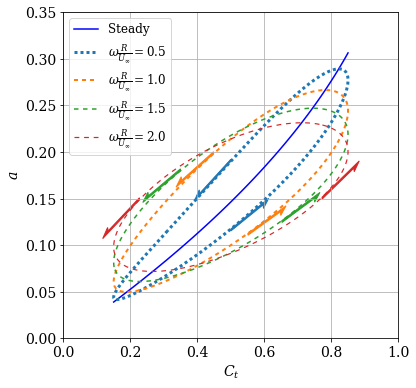

FileNotFoundError: [Errno 2] No such file or directory: 'figures_tutorial_dynamic_inflow/sinusoidal_ct_induction_pitpetters.svg'

In [42]:
# plot figure the change in induction factor $a$  calculated by the Pitt-peters model for a sinusoidal change in thrust coefficient 
# $C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
# The values are made non-dimensioned by the steady-solution values of $a$ 
# for the minimum and maximum values of $C_T$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
# the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

# plot figure
plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')
fig1,ax1 = plt.subplots(figsize=[6,6]) # create figure, axis and define the size of the figure

# plot steady solution of induction as a function of $C_T$
Ctsteady=np.arange(-(Ct0-deltaCt),-(Ct0+deltaCt)+.005,.01) # define an array of $C_T$
asteady= ainduction(Ctsteady) # calculate steady solution of induction as a function of $C_T$

# we plot the steady solution of induction as a function of $C_T$
ax1.plot( Ctsteady, asteady, label='Steady', color='blue') 
 

# we will now plot the unsteady solution 
for j,omegaval in enumerate(omega):
    ind=(-np.floor(2*np.pi/(omegaval*R/Uinf)/dt)-1).astype(int) # indices of the last full cycle to only plot 1 cycle
    label1=r'$\omega \frac{R}{U_\infty}='+np.str(omegaval)+'$' # define label for the legend
    # plot unsteady solution
    plt1=ax1.plot(-Ct[j,ind:], -vind[j,ind:]/Uinf, label=label1, linestyle=(0,(j+1,j+1)), linewidth = (6/(j+2)) ) 
    color = plt1[0].get_color()
    
    # we will plot arrows to see the direction of the cycle
    phase_of_cycle = np.mod(time[ind:]*omegaval*R/Uinf,2*np.pi) # calculate the phase of the different points of the cycle
    i1=np.argmin(np.abs(phase_of_cycle-0))+j*30 # index of start of cycle plotted
    i2=np.argmin(np.abs(phase_of_cycle-np.pi))+j*30 # index of 180 degrees
    scale_arrow=.1 # scale od arrow
    dx = -(Ct[j,ind+i1+1]-Ct[j,ind+i1]) # dx of arrow
    dy = -(vind[j,ind+i1+1]-vind[j,ind+i1])/Uinf  # dy of arrow   
    ax1.arrow(-Ct[j,ind+i1], -vind[j,ind+i1]/Uinf, 
              scale_arrow*dx/np.sqrt(dx**2+dy**2) , scale_arrow*dy/np.sqrt(dx**2+dy**2),
              color=color, width=scale_arrow*.04, shape='left') # plot arrow at 0 degrees of cycle
    dx = -(Ct[j,ind+i2+1]-Ct[j,ind+i2]) # dx of arrow
    dy = -(vind[j,ind+i2+1]-vind[j,ind+i2])/Uinf # dy of arrow   
    ax1.arrow(-Ct[j,ind+i2], -vind[j,ind+i2]/Uinf, scale_arrow*dx/np.sqrt(dx**2+dy**2) ,
              scale_arrow*dy/np.sqrt(dx**2+dy**2),
              color=color, width=scale_arrow*.04, shape='left') # plot arrow at 190 degrees of cycle

# define properties of axis, plot grid and show figure    
ax1.set_xlabel(r'$C_t$') # label of the x-axis
ax1.set_ylabel(r'$a$') # label of the y-axis
ax1.set_xlim(0,1) # set limits of x-axis   
ax1.set_ylim(0,.35) # set limits of x-axis   
plt.legend(fontsize=12) # plot the legend, change fontsize to fit better
plt.grid() # plot grid
plt.show() # show figure

filename = 'figures_tutorial_dynamic_inflow/sinusoidal_ct_induction_pitpetters'
fig1.savefig(filename+'.svg') # save figure
fig1.savefig(filename+'.pdf') # save figure
fig1.savefig(filename+'.png', dpi=300) # save figure




The figure above shows the induction factor $a$  calculated by the Pitt-peters model for a sinusoidal change in thrust coefficient 
$C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
 the unperturbed wind speed $U_\infty$. The arrows show the direction of the cycle. 

The &Oslash;ye dynamic inflow model
----------------------------
The &Oslash;ye dynamic-inflow model differs from the Pitt-Peters model. Instead
of expressing a linear form of the momentum equation, it expresses a
filtering of the quasi-steady values through two first-order
differential equations

$$
\label{eq:oye_dynamic_inflow_model}
v_{int} +\tau_1 \frac{\rm{d} v_{int}}{\rm{d} t}= v_{qs} + 0.6 \tau_1 \frac{\rm{d} v_{qs}}{\rm{d} t} $$

$$v_x + \tau_2 \frac{\rm{d} v_x}{\rm{d} t}= v_{int}$$

$$\tau_1 = \frac{1.1}{1-1.3 a}\frac{R}{U_\infty}$$

$$\tau_2 = \left(\frac{r_j}{R}\right)^2 \tau_1$$



In [20]:
# The Øye dynamic inflow model

def oye_dynamic_inflow(vz, Ct1, Ct2, vint, Uinf, R, r,dt,glauert=False):
    # this function determines the time derivative of the induction at the annulli
    # using the Øye dynamic inflow model
    # Ct is the thrust coefficient on the actuator, vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow,
    # r is the radial position of the annulus. vqs is the quasi-steady value from BEM, 
    #vint is an intermediate value and vz is the induced velocity
    
    # calculate  quasi-steady induction velocity
    vqst1=-ainduction(-Ct1)*Uinf

    # calculate current induction factor
    a=-vz/Uinf

    # calculate time scales of the model
    t1 = 1.1/(1-1.3*a)*R/Uinf
    t2 = (0.39-0.26*(r/R)**2)*t1

    # calculate next-time-step quasi-steady induction velocity
    vqst2=-ainduction(-Ct2)*Uinf
        
    #calculate time derivative of intermediate velocity
    dvint_dt= (vqst1+ (vqst2-vqst1)/dt*0.6*t1 - vint)/t1

    # calculate new intermediate velocity
    vint2 = vint +dvint_dt*dt
    
    #calculate time derivaive of the induced velocity
    dvz_dt = ((vint+vint2)/2-vz)/t2
    
    #calculate new induced velocity
    vz2 = vz +dvz_dt*dt
    return vz2, vint2
    

In [21]:
# we will now calculate and plot the solution of a step change in thrust coefficient using the Oye model

# we define the value of U_infinity and the radius of the actuator
Uinf=1 # U_infinity
R=1 # radius of the actuator

# define time array
dt=0.005 # we define the time step
time=np.arange(0, 20, dt) # we create the array "time"


# define Ct and induction at  t0
Ct0=np.array([-.5])  # this it the value of thrust coefficient at time t0, the start of the time array
vind0=-ainduction(-Ct0)*Uinf # this is the quasi-steady value of induction at time t0, calculated from Ct0

# define quasi-steady solution of Ct and induction at  t>=t1
Ct1=np.array([-0.85]) # this it the value of thrust coefficient at time t1
vind1=-ainduction(-Ct1)*Uinf # this is the quasi-steady value of induction at time t1, calculated from Ct1

# define Ct as a function of time
Ct = np.zeros(np.shape(time))+Ct0 # we initialize the array of thrust coefficient, setting all initial values at Ct0

# change Ct for time above t1
t1=5 # we define t1, when Ct experiences a step change
Ct[time>=t1] = Ct1 # we correct the values of Ct for the instants that time is after t1, to a value of Ct1. We therefore 
                    # define the step change from Ct0 to Ct1
    
#set arrays for induction
vind = np.zeros(np.shape(time)) # we create the array of induction velocity
vind[0]=vind0 # we initialize the first value to the induction velocity at t0, calculated from Ct0

# the Oye model requires the use of atemporaty value of induction vint. Here, we initialize the value of vint
vint=vind0


# solve the equation in time of the value of induction by using the Oye model 
for i,val in enumerate(time[:-1]):
    vind[i+1],vint=oye_dynamic_inflow(vind[i], Ct[i], Ct[i+1], vint, Uinf, R, 0.95*R,dt)    

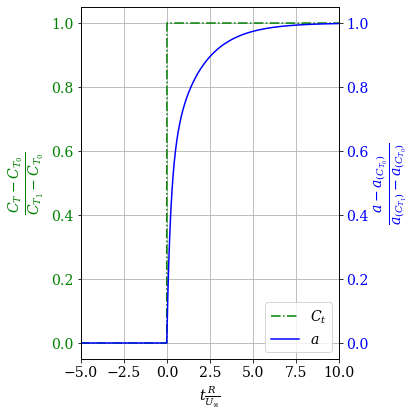

FileNotFoundError: [Errno 2] No such file or directory: 'figures_tutorial_dynamic_inflow/step_change_ct_induction_oye.svg'

In [22]:
# plot figure the change in induction factor $a$  calculated by the Oye model for a step change in thrust coefficient 
# from $C_{t_0}=0.5$ to $C_{t_0}=0.85$. The values are made non-dimensioned by the steady-solution values of $a$ 
# for the two values of $C_t$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
# the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')  # define a colormap for the figure
fig,ax1 = plt.subplots(figsize=[6,6]) # create figure, axis and define the size of the figure
ax2=ax1.twinx() # we twin the axis to create a seondary y-axis. therefore, we twin the x-axis
# we now plot the evolution of Ct over time
lns1=ax1.plot((time-t1)*R/Uinf, (Ct-Ct0)/(Ct1-Ct0), color='green',linestyle='dashdot', label=r'$C_t$') # notice the negative 
                                                              # value as we wil be using the notation for wind tuubines
# we now plot the evolution of induction velocity over time in the secondary axis
lns2=ax2.plot((time-t1)*R/Uinf, (vind-vind0)/(vind1-vind0), color='blue',linestyle='-', label= r'$a$') # notice the negative 

# define properties of the primary y-axis
# ax1.set_aspect(aspect=20.0) # set aspect ratio of the figure
ax1.set_xlabel(r'$t \frac{R}{U_\infty}$') # label of x-axis
ax1.set_ylabel(r'$\frac{C_T-C_{T_0}}{C_{T_1}-C_{T_0}}$', 
               color='green', fontsize=20) # label of y-axis
ax1.set_xlim(-t1,10) # set limits of x-axis   
ax1.set_ylim(-0.05,1.05) # set limits of x-axis   
ax1.tick_params(axis='y', labelcolor='green') # set the color of the axis

# define properties of secondary axis
ax2.set_ylabel(r'$\frac{a-a_{\left(C_{T_0}\right)}}{a_{\left(C_{T_1}\right)}-a_{\left(C_{T_0}\right)}}$',
               color='blue', fontsize=20) # label of y-axis
ax1.set_ylim(-0.05,1.05) # set limits of x-axis   
ax2.tick_params(axis='y', labelcolor='blue')# set the color of the axis

# here we plot the legend of the figure
lns = lns1+lns2 # add legends
labs = [l.get_label() for l in lns] # extract labels
plt.legend(lns, labs, loc='lower right') # plot legend

ax1.grid(axis='both',which='both') # add a grid

plt.tight_layout() # tight layout to avoid cropping labels
plt.show() # show figure

# save figure in three formats: svg, pdf and png
filename = 'figures_tutorial_dynamic_inflow/step_change_ct_induction_oye' # directory and filename
fig.savefig(filename+'.svg') # save figure in svg
fig.savefig(filename+'.pdf') # save figure in pdf
fig.savefig(filename+'.png', dpi=300) # save figure in png



The figure above shows the change in induction factor $a$  calculated by the &Oslash;ye model for a step change in thrust coefficient from $C_{t_0}=0.5$ to $C_{t_0}=0.85$. The values are made non-dimensioned by the steady-solution values of $a$ for the two values of $C_t$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

In [23]:
## we will now plot the solution of the Oye dynamic inflow model for different ranges of reduced frequency

# we define the value of U_infinity and the radius of the actuator
Uinf=1 # U_infinity
R=1 # radius of the actuator

# define time array
dt=0.005 # we define the time step
time=np.arange(0, 20, dt) # we create the array "time"



## we now define the frequencies and amplitudes, takign an array of reduced frequencies and scaling with Uinf and R 
omega=np.arange(0.5,2.1,.5) *Uinf/R 

# we define the variation of thrust coefficient in time
Ct0=np.array([-.5]) # this it the average value of thrust coefficient at time 

# we now define the amplitude of thrust coefficient at time 
deltaCt=np.array([-.35])

# initialize array for induction solution
vind = np.zeros([np.size(omega),np.size(time)])

# initialize array for Ct solution
Ct = np.zeros([np.size(omega),np.size(time)])


# the Oye model requires the use of atemporaty value of induction vint. Here, we initialize the value of vint
vint = np.zeros([np.size(omega)])

# we now initialize all time series for all frequencies
for j,omegaval in enumerate(omega):
    Ct[j,0] = Ct0
    vind[j,0] = -ainduction(-Ct0)*Uinf
    vint[j] = vind[j,0] 
    

# we now solve the equation in time for all frequencies, 
for i,timeval in enumerate(time[:-1]):
    for j,omegaval in enumerate(omega):
        Ct[j,i+1] = Ct0 + deltaCt*np.sin(omegaval*Uinf/R*timeval) # calculate Ct at time {i+1} for the case of frequency {j}
        vind[j,i+1],vint[j]=oye_dynamic_inflow(vind[j,i], Ct[j,i], Ct[j,i+1], vint[j], Uinf, R, 0.95*R,dt)  # calculate induction at 
                                                                                         # time {i+1} for frequency {j}

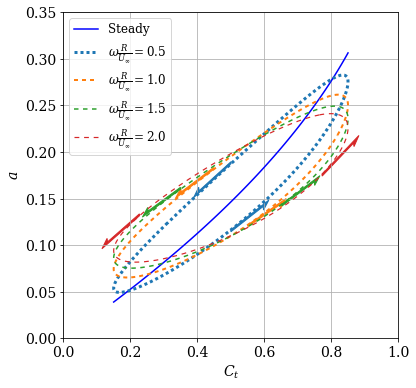

FileNotFoundError: [Errno 2] No such file or directory: 'figures_tutorial_dynamic_inflow/sinusoidal_ct_induction_oye.svg'

In [24]:
# plot figure the change in induction factor $a$  calculated by the Pitt-peters model for a sinusoidal change in thrust coefficient 
# $C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
# The values are made non-dimensioned by the steady-solution values of $a$ 
# for the minimum and maximum values of $C_T$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
# the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

# plot figure
plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')
fig1,ax1 = plt.subplots(figsize=[6,6]) # create figure, axis and define the size of the figure

# plot steady solution of induction as a function of $C_T$
Ctsteady=np.arange(-(Ct0-deltaCt),-(Ct0+deltaCt)+.005,.01) # define an array of $C_T$
asteady= ainduction(Ctsteady) # calculate steady solution of induction as a function of $C_T$

# we plot the steady solution of induction as a function of $C_T$
ax1.plot( Ctsteady, asteady, label='Steady', color='blue') 
 

# we will now plot the unsteady solution 
for j,omegaval in enumerate(omega):
    ind=(-np.floor(2*np.pi/(omegaval*R/Uinf)/dt)-1).astype(int) # indices of the last full cycle to only plot 1 cycle
    label1=r'$\omega \frac{R}{U_\infty}='+np.str(omegaval)+'$' # define label for the legend
    # plot unsteady solution
    plt1=ax1.plot(-Ct[j,ind:], -vind[j,ind:]/Uinf, label=label1, linestyle=(0,(j+1,j+1)), linewidth = (6/(j+2)) ) 
    color = plt1[0].get_color()
    
    # we will plot arrows to see the direction of the cycle
    phase_of_cycle = np.mod(time[ind:]*omegaval*R/Uinf,2*np.pi) # calculate the phase of the different points of the cycle
    i1=np.argmin(np.abs(phase_of_cycle-0))+j*30 # index of start of cycle plotted
    i2=np.argmin(np.abs(phase_of_cycle-np.pi))+j*30 # index of 180 degrees
    scale_arrow=.1 # scale od arrow
    dx = -(Ct[j,ind+i1+1]-Ct[j,ind+i1]) # dx of arrow
    dy = -(vind[j,ind+i1+1]-vind[j,ind+i1])/Uinf  # dy of arrow   
    ax1.arrow(-Ct[j,ind+i1], -vind[j,ind+i1]/Uinf, 
              scale_arrow*dx/np.sqrt(dx**2+dy**2) , scale_arrow*dy/np.sqrt(dx**2+dy**2),
              color=color, width=scale_arrow*.04, shape='left') # plot arrow at 0 degrees of cycle
    dx = -(Ct[j,ind+i2+1]-Ct[j,ind+i2]) # dx of arrow
    dy = -(vind[j,ind+i2+1]-vind[j,ind+i2])/Uinf # dy of arrow   
    ax1.arrow(-Ct[j,ind+i2], -vind[j,ind+i2]/Uinf, scale_arrow*dx/np.sqrt(dx**2+dy**2) ,
              scale_arrow*dy/np.sqrt(dx**2+dy**2),
              color=color, width=scale_arrow*.04, shape='left') # plot arrow at 190 degrees of cycle

# define properties of axis, plot grid and show figure    
ax1.set_xlabel(r'$C_t$') # label of the x-axis
ax1.set_ylabel(r'$a$') # label of the y-axis
ax1.set_xlim(0,1) # set limits of x-axis   
ax1.set_ylim(0,.35) # set limits of x-axis   
plt.legend(fontsize=12) # plot the legend, change fontsize to fit better
plt.grid() # plot grid
plt.show() # show figure

filename = 'figures_tutorial_dynamic_inflow/sinusoidal_ct_induction_oye'
fig1.savefig(filename+'.svg') # save figure
fig1.savefig(filename+'.pdf') # save figure
fig1.savefig(filename+'.png', dpi=300) # save figure




The figure above shows the induction factor $a$  calculated by the &Oslash;ye model for a sinusoidal change in thrust coefficient 
$C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
 the unperturbed wind speed $U_\infty$. The arrows show the direction of the cycle. 

The Larsen-Madsen model
-----------------------
In this model, as in Øye's model, dynamic inflow is modelled using a low
pass filtering of the steady state induced velocities.

$$
\label{sec:larsenmadsenmodel}
a_{t_{i+1}}=a_{t_{i}} e^{\frac{-\Delta t}{\tau}}+a_{qs}\left( 1- e^{\frac{-\Delta t}{\tau}} \right)$$

$$\tau=0.5\frac{R}{U_{wake}}\simeq 0.5\frac{R}{a U_\infty}$$


In [25]:
# the Larsen-Madsen low pass filter model

def larsenmadsen(vz, Ct2, Uinf, R,dt,glauert=False):
    # this function determines the time derivative of the induction at the annulli
    # using the Larsen-Madsen dynamic inflow model
    # Ct2 is the thrust coefficient on the actuator at the next time step, 
    # vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow,
    # R is the radius. vqst2 is the quasi-steady value from momentum theory, 
    
    # calculate velocity wake 
    Vwake=Uinf+vz

    # calculate time scales of the model
    t1 = 0.5*R/Vwake

    # calculate next-time-step quasi-steady induction velocity
    vqst2=-ainduction(-Ct2)*Uinf
    
    #calculate new induced velocity
    vz2 = vz*np.exp(-dt/t1)+vqst2*(1-np.exp(-dt/t1))
    
    return vz2


In [26]:
# we will now calculate and plot the solution of a step change in thrust coefficient

# we define the value of U_infinity and the radius of the actuator
Uinf=1 # U_infinity
R=1 # radius of the actuator

# define time array
dt=0.005 # we define the time step
time=np.arange(0, 20, dt) # we create the array "time"


# define Ct and induction at  t0
Ct0=np.array([-.5])  # this it the value of thrust coefficient at time t0, the start of the time array
vind0=-ainduction(-Ct0)*Uinf # this is the quasi-steady value of induction at time t0, calculated from Ct0

# define quasi-steady solution of Ct and induction at  t>=t1
Ct1=np.array([-0.85]) # this it the value of thrust coefficient at time t1
vind1=-ainduction(-Ct1)*Uinf # this is the quasi-steady value of induction at time t1, calculated from Ct1

# define Ct as a function of time
Ct = np.zeros(np.shape(time))+Ct0 # we initialize the array of thrust coefficient, setting all initial values at Ct0

# change Ct for time above t1
t1=5 # we define t1, when Ct experiences a step change
Ct[time>=t1] = Ct1 # we correct the values of Ct for the instants that time is after t1, to a value of Ct1. We therefore 
                    # define the step change from Ct0 to Ct1
    
#set arrays for induction
vind = np.zeros(np.shape(time)) # we create the array of induction velocity
vind[0]=vind0 # we initialize the first value to the induction velocity at t0, calculated from Ct0


# solve the equation in time of the value of induction by using the Larsen-Madsen model 
for i,val in enumerate(time[:-1]):
    vind[i+1]=larsenmadsen(vind[i], Ct[i+1], Uinf, R,dt)
    

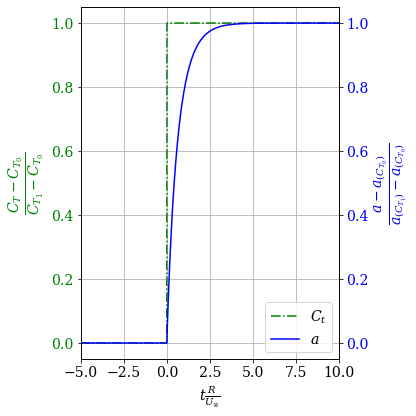

FileNotFoundError: [Errno 2] No such file or directory: 'figures_tutorial_dynamic_inflow/step_change_ct_induction_Larsen_Madsen.svg'

In [27]:
# plot figure the change in induction factor $a$  calculated by the Pitt-peters model for a step change in thrust coefficient 
# from $C_{t_0}=0.5$ to $C_{t_0}=0.85$. The values are made non-dimensioned by the steady-solution values of $a$ 
# for the two values of $C_t$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
# the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')  # define a colormap for the figure
fig,ax1 = plt.subplots(figsize=[6,6]) # create figure, axis and define the size of the figure
ax2=ax1.twinx() # we twin the axis to create a seondary y-axis. therefore, we twin the x-axis
# we now plot the evolution of Ct over time
lns1=ax1.plot((time-t1)*R/Uinf, (Ct-Ct0)/(Ct1-Ct0), color='green',linestyle='dashdot', label=r'$C_t$') # notice the negative 
                                                              # value as we wil be using the notation for wind tuubines
# we now plot the evolution of induction velocity over time in the secondary axis
lns2=ax2.plot((time-t1)*R/Uinf, (vind-vind0)/(vind1-vind0), color='blue',linestyle='-', label= r'$a$') # notice the negative 

# define properties of the primary y-axis
# ax1.set_aspect(aspect=20.0) # set aspect ratio of the figure
ax1.set_xlabel(r'$t \frac{R}{U_\infty}$') # label of x-axis
ax1.set_ylabel(r'$\frac{C_T-C_{T_0}}{C_{T_1}-C_{T_0}}$', 
               color='green', fontsize=20) # label of y-axis
ax1.set_xlim(-t1,10) # set limits of x-axis   
ax1.set_ylim(-0.05,1.05) # set limits of x-axis   
ax1.tick_params(axis='y', labelcolor='green') # set the color of the axis

# define properties of secondary axis
ax2.set_ylabel(r'$\frac{a-a_{\left(C_{T_0}\right)}}{a_{\left(C_{T_1}\right)}-a_{\left(C_{T_0}\right)}}$',
               color='blue', fontsize=20) # label of y-axis
ax1.set_ylim(-0.05,1.05) # set limits of x-axis   
ax2.tick_params(axis='y', labelcolor='blue')# set the color of the axis

# here we plot the legend of the figure
lns = lns1+lns2 # add legends
labs = [l.get_label() for l in lns] # extract labels
plt.legend(lns, labs, loc='lower right') # plot legend

ax1.grid(axis='both',which='both') # add a grid

plt.tight_layout() # tight layout to avoid cropping labels
plt.show() # show figure

# save figure in three formats: svg, pdf and png
filename = 'figures_tutorial_dynamic_inflow/step_change_ct_induction_Larsen_Madsen' # directory and filename
fig.savefig(filename+'.svg') # save figure in svg
fig.savefig(filename+'.pdf') # save figure in pdf
fig.savefig(filename+'.png', dpi=300) # save figure in png



The figure above shows the change in induction factor $a$  calculated by the Larsen-Madsen model for a step change in thrust coefficient from $C_{t_0}=0.5$ to $C_{t_0}=0.85$. The values are made non-dimensioned by the steady-solution values of $a$ for the two values of $C_t$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

In [28]:

## we will now plot the solution of the Larsen-Madsen dynamic inflow model for different ranges of reduced frequency

# we define the value of U_infinity and the radius of the actuator
Uinf=1 # U_infinity
R=1 # radius of the actuator

# define time array
dt=0.005 # we define the time step
time=np.arange(0, 20, dt) # we create the array "time"



## we now define the frequencies and amplitudes, takign an array of reduced frequencies and scaling with Uinf and R 
omega=np.arange(0.5,2.1,.5) *Uinf/R 

# we define the variation of thrust coefficient in time
Ct0=np.array([-.5]) # this it the average value of thrust coefficient at time 

# we now define the amplitude of thrust coefficient at time 
deltaCt=np.array([-.35])

# initialize array for induction solution
vind = np.zeros([np.size(omega),np.size(time)])

# initialize array for Ct solution
Ct = np.zeros([np.size(omega),np.size(time)])

# we now initialize all time series for all frequencies
for j,omegaval in enumerate(omega):
    Ct[j,0] = Ct0
    vind[j,0] = -ainduction(-Ct0)*Uinf


# we now solve the equation in time for all frequencies, 
for i,timeval in enumerate(time[:-1]):
    for j,omegaval in enumerate(omega):
        Ct[j,i+1] = Ct0 + deltaCt*np.sin(omegaval*Uinf/R*timeval) # calculate Ct at time {i+1} for the case of frequency {j}
        vind[j,i+1]=larsenmadsen(vind[j,i], Ct[j,i+1], Uinf, R,dt) # calculate induction at time {i+1} for frequency {j}


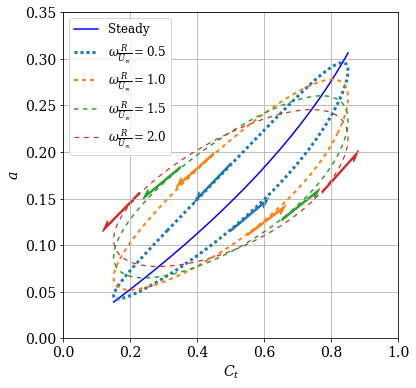

FileNotFoundError: [Errno 2] No such file or directory: 'figures_tutorial_dynamic_inflow/sinusoidal_ct_induction_Larsen_Madsen.svg'

In [29]:
# plot figure the change in induction factor $a$  calculated by the Larsen-Madsen model for a sinusoidal change in thrust coefficient 
# $C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
# The values are made non-dimensioned by the steady-solution values of $a$ 
# for the minimum and maximum values of $C_T$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
# the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

# plot figure
plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')
fig1,ax1 = plt.subplots(figsize=[6,6]) # create figure, axis and define the size of the figure

# plot steady solution of induction as a function of $C_T$
Ctsteady=np.arange(-(Ct0-deltaCt),-(Ct0+deltaCt)+.005,.01) # define an array of $C_T$
asteady= ainduction(Ctsteady) # calculate steady solution of induction as a function of $C_T$

# we plot the steady solution of induction as a function of $C_T$
ax1.plot( Ctsteady, asteady, label='Steady', color='blue') 
 

# we will now plot the unsteady solution 
for j,omegaval in enumerate(omega):
    ind=(-np.floor(2*np.pi/(omegaval*R/Uinf)/dt)-1).astype(int) # indices of the last full cycle to only plot 1 cycle
    label1=r'$\omega \frac{R}{U_\infty}='+np.str(omegaval)+'$' # define label for the legend
    # plot unsteady solution
    plt1=ax1.plot(-Ct[j,ind:], -vind[j,ind:]/Uinf, label=label1, linestyle=(0,(j+1,j+1)), linewidth = (6/(j+2)) ) 
    color = plt1[0].get_color()
    
    # we will plot arrows to see the direction of the cycle
    phase_of_cycle = np.mod(time[ind:]*omegaval*R/Uinf,2*np.pi) # calculate the phase of the different points of the cycle
    i1=np.argmin(np.abs(phase_of_cycle-0))+j*30 # index of start of cycle plotted
    i2=np.argmin(np.abs(phase_of_cycle-np.pi))+j*30 # index of 180 degrees
    scale_arrow=.1 # scale od arrow
    dx = -(Ct[j,ind+i1+1]-Ct[j,ind+i1]) # dx of arrow
    dy = -(vind[j,ind+i1+1]-vind[j,ind+i1])/Uinf  # dy of arrow   
    ax1.arrow(-Ct[j,ind+i1], -vind[j,ind+i1]/Uinf, 
              scale_arrow*dx/np.sqrt(dx**2+dy**2) , scale_arrow*dy/np.sqrt(dx**2+dy**2),
              color=color, width=scale_arrow*.04, shape='left') # plot arrow at 0 degrees of cycle
    dx = -(Ct[j,ind+i2+1]-Ct[j,ind+i2]) # dx of arrow
    dy = -(vind[j,ind+i2+1]-vind[j,ind+i2])/Uinf # dy of arrow   
    ax1.arrow(-Ct[j,ind+i2], -vind[j,ind+i2]/Uinf, scale_arrow*dx/np.sqrt(dx**2+dy**2) ,
              scale_arrow*dy/np.sqrt(dx**2+dy**2),
              color=color, width=scale_arrow*.04, shape='left') # plot arrow at 190 degrees of cycle

# define properties of axis, plot grid and show figure    
ax1.set_xlabel(r'$C_t$') # label of the x-axis
ax1.set_ylabel(r'$a$') # label of the y-axis
ax1.set_xlim(0,1) # set limits of x-axis   
ax1.set_ylim(0,.35) # set limits of x-axis   
plt.legend(fontsize=12) # plot the legend, change fontsize to fit better
plt.grid() # plot grid
plt.show() # show figure

filename = 'figures_tutorial_dynamic_inflow/sinusoidal_ct_induction_Larsen_Madsen'
fig1.savefig(filename+'.svg') # save figure
fig1.savefig(filename+'.pdf') # save figure
fig1.savefig(filename+'.png', dpi=300) # save figure



The figure above shows the induction factor $a$  calculated by the Larsen-Madsen model for a sinusoidal change in thrust coefficient 
$C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
 the unperturbed wind speed $U_\infty$. The arrows show the direction of the cycle. 

## Comparison of the three models

We will now calculate and plot the values of the three models

In [43]:
# we define the value of U_infinity and the radius of the actuator
Uinf=1 # U_infinity
R=1 # radius of the actuator

# define time array
dt=0.005 # we define the time step
time=np.arange(0, 20, dt) # we create the array "time"



## we now define the frequencies and amplitudes, takign an array of reduced frequencies and scaling with Uinf and R 
omega=np.arange(0.5,2.1,.5) *Uinf/R 

# we define the variation of thrust coefficient in time
Ct0=np.array([-.5]) # this it the average value of thrust coefficient at time 

# we now define the amplitude of thrust coefficient at time 
deltaCt=np.array([-.35])

# initialize array for induction solution for the three models
vind = np.zeros([np.size(omega),np.size(time),3])

# initialize array for Ct solution
Ct = np.zeros([np.size(omega),np.size(time)])


# the Oye model requires the use of atemporaty value of induction vint. Here, we initialize the value of vint
vint = np.zeros([np.size(omega)])

# we now initialize all time series for all frequencies
for j,omegaval in enumerate(omega):
    Ct[j,0] = Ct0
    vind[j,0,:] = -ainduction(-Ct0)*Uinf
    vint[j] = vind[j,0,0] 
    

# we now solve the equation in time for all frequencies, 
for i,timeval in enumerate(time[:-1]):
    for j,omegaval in enumerate(omega):
        Ct[j,i+1] = Ct0 + deltaCt*np.sin(omegaval*Uinf/R*timeval) # calculate Ct at time {i+1} for the case of frequency {j}
        vind[j,i+1,0]=pitt_peters(Ct[j,i+1],vind[j,i,0],Uinf,R,dt )[0] # calculate induction at time {i+1} for frequency {j}
        vind[j,i+1,1],vint[j]=oye_dynamic_inflow(vind[j,i,1], Ct[j,i], Ct[j,i+1], vint[j], Uinf, R, .95*R,dt)  # calculate induction at 
                                                                                         # time {i+1} for frequency {j}
        vind[j,i+1,2]=larsenmadsen(vind[j,i,2], Ct[j,i+1], Uinf, R,dt) # calculate induction at time {i+1} for frequency {j}


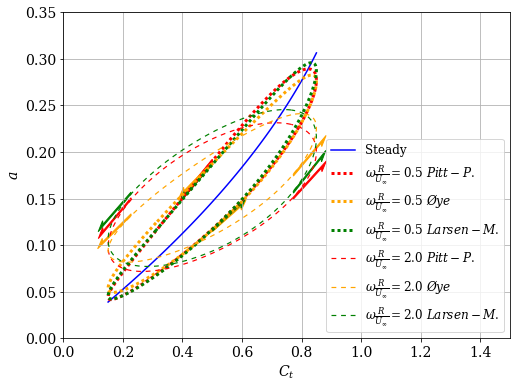

FileNotFoundError: [Errno 2] No such file or directory: 'figures_tutorial_dynamic_inflow/sinusoidal_ct_induction_PP_Oye_LM.svg'

In [44]:
# plot figure the change in induction factor $a$  calculated by the Pitt-Peters, Oye, Larsen-Madsen model for a sinusoidal change in thrust coefficient 
# $C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
# The values are made non-dimensioned by the steady-solution values of $a$ 
# for the minimum and maximum values of $C_T$. Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
# the unperturbed wind speed $U_\infty$, and set to zero at the moment of the step change.

# plot figure
plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')
fig1,ax1 = plt.subplots(figsize=[8,6]) # create figure, axis and define the size of the figure

# plot steady solution of induction as a function of $C_T$
Ctsteady=np.arange(-(Ct0-deltaCt),-(Ct0+deltaCt)+.005,.01) # define an array of $C_T$
asteady= ainduction(Ctsteady) # calculate steady solution of induction as a function of $C_T$

# we plot the steady solution of induction as a function of $C_T$
ax1.plot( Ctsteady, asteady, label='Steady', color='blue') 
 
models = ['Pitt-P.','\O ye','Larsen-M.']
# we will now plot the unsteady solution 
colors = ['red','orange','green']

# for j,omegaval in enumerate(omega):
for j in [0,3]:  # we will only plot two sets as nto to overload the plot
    omegaval = omega[j]
    ind=(-np.floor(2*np.pi/(omegaval*R/Uinf)/dt)-1).astype(int) # indices of the last full cycle to only plot 1 cycle
    
    
    
    for k in range(3):
        label1=r'$\omega \frac{R}{U_\infty}='+np.str(omegaval)+'$ $'+models[k]+'$' # define label for the legend
        # plot unsteady solution
        ax1.plot(-Ct[j,ind:], -vind[j,ind:,k]/Uinf, label=label1, 
                 linestyle=(0,(j+1,j+1)), linewidth = (6/(j+2)) , color=colors[k]) 

        # we will plot arrows to see the direction of the cycle
        phase_of_cycle = np.mod(time[ind:]*omegaval*R/Uinf,2*np.pi) # calculate the phase of the different points of the cycle
        i1=np.argmin(np.abs(phase_of_cycle-0))+j*30 # index of start of cycle plotted
        i2=np.argmin(np.abs(phase_of_cycle-np.pi))+j*30 # index of 180 degrees
        scale_arrow=.1 # scale od arrow
        dx = -(Ct[j,ind+i1+1]-Ct[j,ind+i1]) # dx of arrow
        dy = -(vind[j,ind+i1+1,k]-vind[j,ind+i1,k])/Uinf  # dy of arrow   
        ax1.arrow(-Ct[j,ind+i1], -vind[j,ind+i1,k]/Uinf, 
                  scale_arrow*dx/np.sqrt(dx**2+dy**2) , scale_arrow*dy/np.sqrt(dx**2+dy**2),
                  color=colors[k], width=scale_arrow*.04, shape='left') # plot arrow at 0 degrees of cycle
        dx = -(Ct[j,ind+i2+1]-Ct[j,ind+i2]) # dx of arrow
        dy = -(vind[j,ind+i2+1,k]-vind[j,ind+i2,k])/Uinf # dy of arrow   
        ax1.arrow(-Ct[j,ind+i2], -vind[j,ind+i2,k]/Uinf, scale_arrow*dx/np.sqrt(dx**2+dy**2) ,
                  scale_arrow*dy/np.sqrt(dx**2+dy**2),
                  color=colors[k], width=scale_arrow*.04, shape='left') # plot arrow at 190 degrees of cycle

# define properties of axis, plot grid and show figure    
ax1.set_xlabel(r'$C_t$') # label of the x-axis
ax1.set_ylabel(r'$a$') # label of the y-axis
ax1.set_xlim(0,1.5) # set limits of x-axis   
ax1.set_ylim(0,.35) # set limits of x-axis   
plt.legend(fontsize=12, loc='lower right') # plot the legend, change fontsize to fit better
plt.grid() # plot grid
plt.show() # show figure

filename = 'figures_tutorial_dynamic_inflow/sinusoidal_ct_induction_PP_Oye_LM'
fig1.savefig(filename+'.svg') # save figure
fig1.savefig(filename+'.pdf') # save figure
fig1.savefig(filename+'.png', dpi=300) # save figure


The figure above shows the induction factor $a$  calculated by the Pitt-Peters, &Oslash;ye and Larsen-Madsen models for a sinusoidal change in thrust coefficient 
$C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
Time $t$ is made non-dimensional by the radius of the actuator $R$ and 
 the unperturbed wind speed $U_\infty$. The arrows show the direction of the cycle. 

### Calculate the amplitude damping and the phase delay for all models for different frequencies

Amplitude damping and the phase delay are a function of the reduced frequency of the perturbation. We will now calcualte these values for the different models for different reduced frequencies



In [17]:
# we define the value of U_infinity and the radius of the actuator
Uinf=1 # U_infinity
R=1 # radius of the actuator

# define time array
dt=0.01 # we define the time step
time=np.arange(0, 200, dt) # we create the array "time"



## we now define the frequencies and amplitudes, takign an array of reduced frequencies and scaling with Uinf and R 
omega=np.arange(0.05,2.51,.25) *Uinf/R 

# we define the variation of thrust coefficient in time
Ct0=np.array([-.5]) # this it the average value of thrust coefficient at time 

# we now define the amplitude of thrust coefficient at time 
deltaCt=np.array([-.35])

# initialize array for induction solution for the three models
vind = np.zeros([np.size(omega),np.size(time),3])

# initialize array for Ct solution
Ct = np.zeros([np.size(omega),np.size(time)])


# the Oye model requires the use of atemporaty value of induction vint. Here, we initialize the value of vint
vint = np.zeros([np.size(omega)])

# we now initialize all time series for all frequencies
for j,omegaval in enumerate(omega):
    Ct[j,0] = Ct0
    vind[j,0,:] = -ainduction(-Ct0)*Uinf
    vint[j] = vind[j,0,0] 
    

# we now solve the equation in time for all frequencies, 
for i,timeval in enumerate(time[:-1]):
    for j,omegaval in enumerate(omega):
        Ct[j,i+1] = Ct0 + deltaCt*np.sin(omegaval*Uinf/R*timeval) # calculate Ct at time {i+1} for the case of frequency {j}
        vind[j,i+1,0]=pitt_peters(Ct[j,i+1],vind[j,i,0],Uinf,R,dt )[0] # calculate induction at time {i+1} for frequency {j}
        vind[j,i+1,1],vint[j]=oye_dynamic_inflow(vind[j,i,1], Ct[j,i], Ct[j,i+1], vint[j], Uinf, R, .5*R,dt)  # calculate induction at 
                                                                                         # time {i+1} for frequency {j}
        vind[j,i+1,2]=larsenmadsen(vind[j,i,2], Ct[j,i+1], Uinf, R,dt) # calculate induction at time {i+1} for frequency {j}


NameError: name 'oye_dynamic_inflow' is not defined

In [18]:

# plot steady solution of induction as a function of $C_T$
Ctsteady=np.arange(-(Ct0-deltaCt),-(Ct0+deltaCt)+.005,.01) # define an array of $C_T$
asteady= ainduction(Ctsteady) # calculate steady solution of induction as a function of $C_T$

# steady amplitude 
amplistd=asteady[-1]-asteady[0]

# we now calculate the amplitude and phase delay for each case


# iinitialize array for amplitude
ampl = np.zeros([np.size(omega),3])

# initialize array for phase_delay
phase_delay = np.zeros([np.size(omega),3])

for j,omegaval in enumerate(omega): # for-cycle over all frequencies
    ind=(-np.floor(2*np.pi/(omegaval*R/Uinf)/dt)-1).astype(int) # indices of the last full cycle to only plot 1 cycle
        
    for k in range(3):
        # we will plot arrows to see the direction of the cycle
        atemp = -vind[j,ind:,k]/Uinf # create temporary array of induction factor for the cycle
        phase_of_cycle = np.mod(time[ind:]*omegaval*R/Uinf,2*np.pi) # calculate the phase of the different points of the cycle
        
        i1=np.argmax(atemp) # index of start of cycle plotted
        i2=np.argmin(atemp) # index of 180 degrees        
        
        ampl[j,k]=atemp[i1]-atemp[i2] # determine 2*amplitude of induction factor 
        phase_delay[j,k] = (phase_of_cycle[i1]-np.pi/2)*180/np.pi # determine phase delay at maximum induction


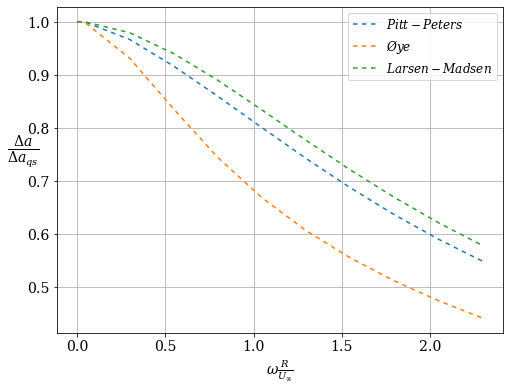

In [22]:
models = ['Pitt-Peters','\O ye','Larsen-Madsen']

# plot figure
plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')
fig1,ax1 = plt.subplots(figsize=[8,6]) # create figure, axis and define the size of the figure

for i in range(3):
    label1=r'$'+models[i]+'$' # define label for the legend
    # we plot the steady solution of induction as a function of $C_T$
    ax1.plot( np.append(0, omega), np.append(1, ampl[:,i]/amplistd), label=label1,linestyle=(0,(k+1,k+1)), linewidth = (6/(k+2)))
    
# define properties of axis, plot grid and show figure    
ax1.set_xlabel(r'$\omega \frac{R}{U_\infty}$') # label of the x-axis
ax1.set_ylabel(r'$\frac{\Delta a}{\Delta a_{qs}}$', rotation=0, fontsize=20) # label of the y-axis
# ax1.set_xlim(0,1.5) # set limits of x-axis   
# ax1.set_ylim(0,.35) # set limits of x-axis   
plt.legend(fontsize=12, loc='upper right') # plot the legend, change fontsize to fit better
plt.grid() # plot grid
plt.show() # show figure

filename = 'figures_tutorial_dynamic_inflow/sinusoidal_amplitude_PP_Oye_LM'
fig1.savefig(filename+'.svg') # save figure
fig1.savefig(filename+'.pdf') # save figure
fig1.savefig(filename+'.png', dpi=300) # save figure




The figure above shows the change in amplitude of induction factor $\Delta a$ as a function of the frequency of the sinusoidal variation of the thrust coefficient, as calculated by the Pitt-Peters, &Oslash;ye and Larsen-Madsen models for a sinusoidal change in thrust coefficient 
$C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. $\Delta a$ is made non-dimensional by the quasi-steady value. 
The frequency $\omega$ is made non-dimensional by the radius of the actuator $R$ and 
 the unperturbed wind speed $U_\infty$.  

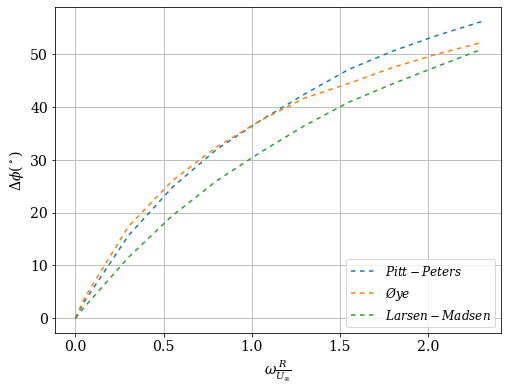

In [23]:
models = ['Pitt-Peters','\O ye','Larsen-Madsen']

# plot figure
plt.rcParams.update({'font.size': 14}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions
# cmap = plt.get_cmap('BuGn')
fig1,ax1 = plt.subplots(figsize=[8,6]) # create figure, axis and define the size of the figure

for i in range(3):
    label1=r'$'+models[i]+'$' # define label for the legend
    # we plot the steady solution of induction as a function of $C_T$
    ax1.plot( np.append(0, omega), np.append(0, phase_delay[:,i]), label=label1,linestyle=(0,(k+1,k+1)), linewidth = (6/(k+2)))
    
# define properties of axis, plot grid and show figure    
ax1.set_xlabel(r'$\omega \frac{R}{U_\infty}$') # label of the x-axis
ax1.set_ylabel(r'$\Delta \phi (^\circ)$') # label of the y-axis
# ax1.set_xlim(0,1.5) # set limits of x-axis   
# ax1.set_ylim(0,.35) # set limits of x-axis   
plt.legend(fontsize=12, loc='lower right') # plot the legend, change fontsize to fit better
plt.grid() # plot grid
plt.show() # show figure

filename = 'figures_tutorial_dynamic_inflow/sinusoidal_phase_delay_PP_Oye_LM'
fig1.savefig(filename+'.svg') # save figure
fig1.savefig(filename+'.pdf') # save figure
fig1.savefig(filename+'.png', dpi=300) # save figure



The figure above shows the phase delay of induction factor $\Delta a$ (in degrees) as a function of the frequency of the sinusoidal variation of the thrust coefficient, as calculated by the Pitt-Peters, &Oslash;ye and Larsen-Madsen models for a sinusoidal change in thrust coefficient 
$C_{T}= C_{T_0}+\Delta C_T \sin\left(\omega t \right)$, with $C_{T_0}=0.5$ and $\Delta C_{T}=0.35$. 
The frequency $\omega$ is made non-dimensional by the radius of the actuator $R$ and 
 the unperturbed wind speed $U_\infty$.  